
# Mini Project 2
## Advanced Geopandas: spatial join and geoprocessing

**Names:** Enrique Sanchez, Parker Addison

We will be exploring several common geospatial computations in this mini project.  Our goal is to practice different requests against a single layer, and then to join several layers using real data.  In this project we will demonstrate geopandas mastery and also gain experience discovering datasets and critically evaluating metadata.

Find multiple datasets, and for each one explore its metadata.  In addition, provide a brief description of the dataset including the data-integrity characteristics we explored in class, as well as any data quality considerations—especially those which may impact geometric processing.

In this project there is one warm-up problem, and one large, real-world problem that the City of San Diego is actively trying to address.  The best creative and rigorous solutions to this larger problem will be asked to demonstrate to the ScaleSD folks who are visiting to give an invited talk about smart cities.

In [1]:
%matplotlib inline 
import geopandas as gpd
import pandas as pd

# add packages as needed
import shapely
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

---

## Part I.

Using an administrative boundaries map of California, find San Diego county and return its CRS, polygon coordinates, area (use sq. miles), bounding box (use latitude and logitude), and a list of neighboring counties.

To be more general, create a function to return the above geometric characteristics and a list of neighbors of any chosen polygon in a given input dataframe.  The chosen polygon will have a given `name` which exists in a given `name_field` in the dataframe.

### Part I Dataset Description

**Title:** CA Geographic Boundaries

**URL:** https://data.ca.gov/dataset/ca-geographic-boundaries

**Number of records:** 58

**CRS:** EPSG: 3857

**Description:**
This data set contains the shapefile boundaries (EPSG:3857) for all 58 counties in California. It comes from the US Census Bureau's MAF/TIGER database and reflects the governmental units in California as of January 1, 2016. The data set was first released on February 2, 2017 and most recently modified on February 27, 2019. 

In [2]:
### YOUR CODE HERE ###

def poly_info(input_gdf, name_field, name):
    
    sqfeet_to_sqmiles = 1 / 27878400
    
    # Note that it's likely only one entry will exist for a given name, but to
    # be safe we should dissolve first.
    gdf = input_gdf.dissolve(name_field).reset_index().copy()
    
    # Retrieving desired polygon
    poly = gdf[gdf[name_field] == name].reset_index(drop=True)
    
    # Getting coordinate reference system
    crs = poly.crs
    
    # Getting polygon coordinates
    poly_coords = poly['geometry'].iloc[0]
    
    # Calculating area, ensuring epsg 2230 for accuracy
    area = poly.to_crs({'init': 'epsg:2230'}).area.iloc[0] * sqfeet_to_sqmiles
    
    # Getting coordinates for bounding box
    bounding_box = poly.to_crs({'init': 'epsg:4326'}).bounds
    
    # Getting neighbors of the polygon
    neighbors_df = gdf[gdf.touches(poly_coords)]
    neighbors = list(neighbors_df[name_field])
    

    return crs, poly_coords, area, bounding_box, neighbors

In [3]:
# Running the function with our real dataset.

input_gdf = gpd.read_file('Counties/CA_Counties_TIGER2016.shp')
name_field = 'NAMELSAD'
name = 'San Diego County'

crs,poly_coords,area,bbox,neighbors = poly_info(input_gdf, name_field, name)

In [4]:
print(crs)
print(repr(poly_coords))
print(area)
print(bbox)
print(neighbors)

{'init': 'epsg:3857'}
4525.420823895433
         minx       miny        maxx      maxy
0 -117.611093  32.528837 -116.080952  33.50503
['Imperial County', 'Orange County', 'Riverside County']


---
## Part II.

In low and medium income neighborhoods (LMI), food choices are often limited, as these areas may lack healthy food stores or fresh food delivery mechanisms.  Or perhaps there are more fast food options than fresh produce stores.  Where the population is relatively poor, healthy food options isn't been an overwhelming priority for many households.  These areas are referred to as "food deserts".

See these articles:
* https://www.sandiegouniontribune.com/news/data-watch/sdut-san-diego-food-deserts-2016may15-htmlstory.html (see food desert definitions here)
* https://www.npr.org/sections/thesalt/2013/03/13/174112591/how-to-find-a-food-desert-near-you
* https://www.geospatial.institute/wp-content/uploads/2018/03/Mapping-Food-Desserts-in-Southern-California-Counties.pdf 
* https://www.sandiegoreader.com/news/2018/sep/04/stringers-imperial-beach-food-desert/# (a recent one, about IB)
* https://www.kpbs.org/news/2018/mar/29/sdsu-students-take-food-deserts-national-city/
* http://newscenter.sdsu.edu/sdsu_newscenter/news_story.aspx?sid=74890 
* https://grist.org/food/americas-worst-food-deserts-map-lovers-edition/
* https://ucsdcommunityhealth.org/news/promoting-produce-consumption/

There was also a Master's thesis at UCSD: https://escholarship.org/uc/item/0s78j9g2

Don't read them all, just skim to understand the issues and get ideas.

We'll analyze the current business state of food deserts by looking at lists of businesses in San Diego as well as by using demographic census-tract data from SanDAG.

We will use the City of San Diego tax certificates for our list of businesses.  This dataset is current and includes location, as well as detailed NAICS codes for each business.  We want to look at only active certificates, and we want to determine which types of businesses are relevant to healthy and unhealthy food options.  We have provided a list of healthy and unhealthy NAICS as part of the assignment.  You may use this or modify it if you wish.

We will also use relevant spatial data layers from SanDAG.  Namely the Promise Zone and Census Tract boundaries.  Descriptions of promise zones can be found at the following links:
* https://www.hud.gov/sites/documents/SAN-DIEGO_ZONE_3RD.PDF
* https://www.sandiego.gov/economic-development/sdpromisezone/maps
* https://www.sandiego.gov/economic-development/sdpromisezone

Social-demographic data by census tract can likewise be downloaded from SanDAG.

**Your tasks:**

1. Download all relevant data reading them into geopandas dataframes and merging social-demographic information as necessary.

2. Determine which businesses provide food options, and which should be considered healthy/unhealthy.  Justify your choices if you deviate from the list we provide.

3. Determine which census tracts intersect with the Promise Zone, and which of the remaining tracts are within the boundary of the City of San Diego.

4. For Promise Zone tracts, as well as other tracts within city limits, calculate the number of healthy and unhealthy food options within the tract.

5. Compute the ratio of healthy to unhealthy options, and build a regression model to showcase possible dependence on social-demographic characteristics of the tract. Start with linear regression. Provide a brief description of regression results.

6. Create a map displaying the above ratio in each census tract, and displaying the locations of healthy food options.

We won't provide a skeleton for this problem. This is a much more open project than before. 


### Part 2 Dataset Descriptions

---

**Title:** Business Tax Certificates

**URL:** https://data.sandiego.gov/datasets/business-listings/

**Number of records:** 39978

**CRS:** N/A

**Description:** This data set includes all active businesses since 2008 in San Diego. It is maintained by the City of San Diego and has been frequently updated (last modified on April 18, 2019 although we are unsure of the version provided to us in this mini project).

---

**Title:** Promise Zone SD

**URL:** http://rdw.sandag.org/Account/gisdtview?dir=Business

**Number of records:** 1

**CRS:** ESPG 2230

**Description:** This data set contains the shapefiles for the San Diego Promise Zone and is current as of June of 2016. According to the metadata, the information is within a 5% range of accuracy and is provided for general information purposes only.

---

**Title:** Census Tracts 2010

**URL:** http://rdw.sandag.org/Account/gisdtview?dir=Census

**Number of records:** 627

**CRS:** ESPG 2230

**Description:** This data set contains the shapefiles for the 2010 census tracts for San Diego County. As can be expected, this data was collected for the purpose of the US census. The metadata suggests that the the positional accuracy of each tract (polygon) may not exactly match their exact locations.

---

**Title:** San Diego City Boundary

**URL:** https://data.sandiego.gov/datasets/san-diego-boundary/

**Number of records:** 70

**CRS:** ESPG 2230

**Description:** This data set contains the shapefiles for City of San Diego administrative boundary. It is maintained by SanGIS and has last been modified on April 9, 2019. The data is updated when notified by LAFCO about a new annexation or detachment in order to ensure the accuracy of the data set.

---

**Title:** Deomgrographic & Socio Economic Estimates

**URL:** http://datasurfer.sandag.org/

**Number of records:** 43890

**CRS:** N/A

**Description:** This data set by SANDAG contains demographic and socio economic estimates for households in San Diego based on the 2010 census. It is noted by SANDAG that the census did not include information about structure type or household income. Therefore, they acquired this information from other sources such as the County of San Diego. It is also noted that minor adjustments were made to more accurately reflect the population and housing distribution.

---

In [5]:
### YOUR CODE HERE ###

1. Download the data - promise zone, census tracts, jurisdictions (census tracts social-demographic data and businesses data are provided but you can download as well if you wish), read them into geopandas dataframes, and merge social-demographic data with tract boundaries as needed.

In [13]:
tracts = gpd.read_file("Census_Tracts/CENSUS_TRACTS_2010.shp")
# We noticed some rows that were exact duplicates of one another.  This could mess with our counts of healthy
# and unhealthy food options, so let's keep just the first to be safe!
#
# For an example of duplicated rows, look at businesses where dba_name == "ZANZIBAR CAFE III INC".
# This particular food option is located outside of San Diego City, so it wouldn't affect our final
# analysis, but it doesn't hurt to be safe!
businesses = pd.read_csv("sd_businesses_active_since08_datasd.csv").drop_duplicates()
socio = pd.read_excel("socio-demographic.xlsx")

sandiego = gpd.read_file("SanDiego/san_diego_boundary_datasd.shp")
promise = gpd.read_file("Promise_Zones/Promise_Zone_SD.shp")

# The socio-demographic data and the census tracts data have identical "TRACT" columns.
#
# The dataframe resulting from their merge should be converted into a GeoDataFrame in
# order to utilize geopandas in future steps.
#
# By calling merge from the gdf, we preserve the crs.
socio_geo = tracts.merge(socio, how="right", on="TRACT")

2. Subset the businesses (figure out, from NAICS descriptions, which businesses are likely to provide healthy food options, and which unhealthy. You can use our suggestions above but also feel free to deviate from them as long as you justify your choices.)

In [14]:
#! NOTE: We considered moving 'FULL-SERVICE RESTAURANTS' to the list of healthy NAICS, but ultimately
#  decided against this decision when we found that places like McDonalds and Burger King were listed
#  as full-service.
#
#  In a perfect world, we would have the time to create an additional classifier for full service
#  restaurants to further distinguish between healthy and unhealthy restaurants.
healthy_naics = ["FOOD (HEALTH) SUPPLEMENT STORES", "GROCERY STORES", "GROCERY (EXCEPT CONVENIENCE) STORES"]

unhealthy_naics = ["FOOD SERVICES & DRINKING PLACES", "LIMITED-SERVICE EATING PLACES", "FULL-SERVICE RESTAURANTS",
             "LIMITED-SERVICE RESTAURANTS", "BEER, WINE & LIQUOR STORES", "TOBACCO STORES", "CONVENIENCE STORES"]

def add_points_from_lat_lon(df):
    """
    Takes a pandas dataframe which has a 'latitude' and 'longitude' column and returns a GeoDataFrame with
    the geometry column containing the corresponding Shapely Points.
    """
    
    points = df.apply(lambda row: shapely.geometry.Point(row.longitude, row.latitude), axis=1)
    
    # This will be in EPSG:4326 since we're using lon-lat points.
    return gpd.GeoDataFrame(df, geometry=points, crs={"init": "epsg:4326"})

healthy_businesses = add_points_from_lat_lon(
    businesses[businesses.naics_description.isin(healthy_naics)]
)
unhealthy_businesses = add_points_from_lat_lon(
    businesses[businesses.naics_description.isin(unhealthy_naics)]
)

3. Determine census tracts intersecting with the promise zone, and all other census tracts within the boundary of San Diego.

In [15]:
# Fortunately, `tracts`, `promise` and `sandiego` are all in EPSG:2230 already!
#
# QUESTION: Would geopandas take care of the conversion if two different crs's
# were used?
#
# ANSWER: No.
# ```
# >>> gpd.sjoin(tracts, promise.to_crs(epsg=4326), how="left", op="intersects")
# UserWarning: CRS of frames being joined does not match!
# ```

promise_tracts = gpd.sjoin(tracts, promise, how="inner", op="intersects")

# Note that the boundaries for San Diego City have objectid 40.  We're interested in
# "other census tracts within the boundary of San Diego", so we use "within" as the operation.
sd_city_tracts = gpd.sjoin(tracts, sandiego[sandiego.objectid==40], how="inner", op="within")

# We want to compare the Promise Zone to the rest of the city's tracts, not to themselves!
#
#! NOTE: Errors are being ignored because there are some tracts that *intersect* with the promise zone,
#  but are not *within* San Diego City, so attempting to drop those indices causes the error.
sd_city_tracts_not_promise = sd_city_tracts.drop(index=promise_tracts.index, axis=0, errors="ignore")

# If we want just the tract numbers, we can just access the TRACT column of `promise_tracts`
# and `sd_city_tracts_not_promise`
print("Tracts *intersecting* with Promise Zone:\n", promise_tracts.TRACT.values)
print("Tracts *within* San Diego City boundaries:\n", sd_city_tracts_not_promise.TRACT.values)

Tracts *intersecting* with Promise Zone:
 [ 33.01  33.03  33.04  33.05  30.01  30.03  30.04  31.01  31.03  31.11
  31.12  31.13  34.03  34.04  35.01  35.02  36.01  36.02  36.03  38.
  39.01  39.02  40.    41.    46.    47.    48.    49.    50.    51.
  52.    54.   118.02 119.02  99.02]
Tracts *within* San Diego City boundaries:
 [ 15.    16.    17.    18.    19.    20.01  20.02  21.    22.01  22.02
  23.01  23.02  24.01  24.02  25.01  25.02  26.01  26.02  27.02   1.
   2.01   2.02   3.     4.     5.     6.     7.     8.     9.    10.
  11.    12.    13.    14.    32.11  34.01  27.05  27.07  27.08  27.09
  27.1   27.11  28.01  28.03  28.04  29.03  29.04  31.05  31.14  31.15
  66.    68.01  68.02  69.    70.02  71.    73.02  74.    75.01  77.01
  77.02  78.    79.03  42.    43.    44.    45.01  53.    55.    56.
  57.    58.    59.    60.    61.    62.    63.    65.    83.29  83.3
  83.31  83.33  83.35  83.36  83.37  83.4   83.41  83.43  83.44  79.07
  79.08  80.02  83.01  83.03  83.05 

4. For each census tract marked as belonging to the promise zone, and the other tracts within the city limits, calculate the number of healthy and not-healthy options within that tract.

In [16]:
# Start by turning all of the lon-lat points into the same crs as our other geometries. (May take a while)
healthy_businesses_2230 = healthy_businesses.to_crs({"init": "epsg:2230"})
unhealthy_businesses_2230 = unhealthy_businesses.to_crs({"init": "epsg:2230"})

In [116]:
# Let's find out which tracts our healthy and unhealthy food businesses are in.
healthy_businesses_tracts = (
    gpd.sjoin(healthy_businesses_2230, tracts[["TRACT", "geometry"]], how="inner", op="within").TRACT
)

unhealthy_businesses_tracts = (
    gpd.sjoin(unhealthy_businesses_2230, tracts[["TRACT", "geometry"]], how="inner", op="within").TRACT
)

# We want to return two dataframes, indexed by tract, which contains columns counting the number
# of healthy and unhealthy businesses within that tract, respectively.

# Note that the value counts of `healthy(unhealthy)_business_tracts` gives the number of healthy(unhealthy)
# businesses per tract (tract is the index).
promise_health_counts = promise_tracts.TRACT.to_frame().set_index("TRACT").assign(
    healthy_count=healthy_businesses_tracts.value_counts(),
    unhealthy_count=unhealthy_businesses_tracts.value_counts()
)

other_health_counts = sd_city_tracts_not_promise.TRACT.to_frame().set_index("TRACT").assign(
    healthy_count=healthy_businesses_tracts.value_counts(),
    unhealthy_count=unhealthy_businesses_tracts.value_counts()
)

In [117]:
display(promise_health_counts.head())
print(promise_health_counts.count())
print(other_health_counts.count())

,healthy_count,unhealthy_count
TRACT,,
33.01,NaN,3.0
33.03,NaN,1.0
33.04,1.0,4.0
33.05,1.0,2.0
30.01,NaN,NaN


healthy_count      13
unhealthy_count    25
dtype: int64
healthy_count       54
unhealthy_count    139
dtype: int64


In [118]:
# Finally we can merge these counts back with our tracts data.
promise_tracts_health = promise_tracts.merge(promise_health_counts, on="TRACT")
other_tracts_health = sd_city_tracts_not_promise.merge(other_health_counts, on="TRACT")

5. Compute the ratio of healthy and non-healthy options, and build a regression model showing how it depends on social-demographic characteristics, such as median income or number of people in lowest and highest income brackets. You may use sklearn on this dataframe by tracts to compute a linear regresson. Provide a brief description of regression results.

In [132]:
# We want:
#
# healthy | unhealthy
# --------|----------
#       i |      NaN   --> Max ratio
#     NaN |        i   --> Zero
#     NaN |      NaN   --> NaN (will be dropped)

# There are some concerns that arise with this:
# e.g. should a single healthy option without any unhealthy options truly warrant the maximum ratio?
#
# However, for the purpose of utilizing as much data as possible, it makes sense that we should find
# a way to compute ratios where one of the counts is zero (NaN) as opposed to completely ignoring the
# row!

def compute_ratios(counts_df):
    """
    Takes as input the healthy and unhealthy counts columns as a dataframe.
    Returns the ratio of healthy/unhealthy with the additional conditions:
    - non-null healthy counts divided by null unhealthy counts will return the maximum of all other
      calculated ratios
    - null healthy counts divided by non-null unhealthy counts will return a ratio of zero
    """
    
    normal_ratios = counts_df.healthy_count / counts_df.unhealthy_count
    max_ratio = normal_ratios.max()
    
    def compute(row):
        if pd.isnull(row.healthy_count) and pd.isnull(row.unhealthy_count):
            return np.NaN
        elif pd.notnull(row.healthy_count) and pd.isnull(row.unhealthy_count):
            
            #! IMPORTANT: THIS MAY COMMENTED OUT TO RETURN MAX OR RETURN NAN.
            return max_ratio
            # return np.NaN
            
        elif pd.isnull(row.healthy_count) and pd.notnull(row.unhealthy_count):
            return 0
        else:
            return row.healthy_count / row.unhealthy_count
    
    return counts_df.apply(compute, axis=1)

    
promise_tracts_health["ratio"] = compute_ratios(promise_tracts_health[["healthy_count", "unhealthy_count"]])
other_tracts_health["ratio"] = compute_ratios(other_tracts_health[["healthy_count", "unhealthy_count"]])

In [133]:
print("Number of ratios for promise zone tracts: %d" % promise_tracts_health.ratio.count())
print("Number of ratios outside promise zone but within SD city: %d" % other_tracts_health.ratio.count())

Number of ratios for promise zone tracts: 26
Number of ratios outside promise zone but within SD city: 144


In [134]:
print("Average ratio for promise zone tracts: %f" % promise_tracts_health.ratio.mean())
print("Average ratio outside promise zone but within SD city: %f" % other_tracts_health.ratio.mean())

Average ratio for promise zone tracts: 0.233814
Average ratio outside promise zone but within SD city: 0.176882


In [263]:
# We're going to want to compare the ratio for a tract with various information about its income levels.

# Before to can do this, we should cut down on the size of our socio_geo df by only looking at the most
# recently reported statistics.
socio_recent = socio_geo[socio_geo.YEAR == socio_geo.YEAR.max()]

# Let's develop a couple functions to take this data (10 income bins and their corresponding counts)
# and extract a single object of useful information.
def extract_median_bin(df):
    """
    Takes in a dataframe with INCOME GROUP and HOUSEHOLDS (a count for each bin) and returns the median
    income group.
    """
    
    total_households = df.HOUSEHOLDS.sum()
    
    median_household_number = total_households / 2
    
    median_group = df.loc[df.HOUSEHOLDS.cumsum() >= median_household_number, "INCOME GROUP"].iloc[0]
    
    return median_group

# The total number of households might be nice to look at.
def total_households(df):
    """
    Takes in a dataframe containing information for a single tract and returns the total number of 
    households within that tract.
    """
    return df['HOUSEHOLDS'].sum()

In [290]:
# We can also return every piece of info as a series, so that we can add them as rows.
def info_to_series(tract):

    return tract[["INCOME GROUP", "HOUSEHOLDS"]].set_index("INCOME GROUP").HOUSEHOLDS

In [136]:
socio_recent[socio_recent.TRACT == 16]

,TRACT,SHAPE_AREA,SHAPE_LEN,geometry,YEAR,ORDINAL,INCOME GROUP,HOUSEHOLDS
120,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,1,"Less than $15,000",552
121,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,2,"$15,000 to $29,999",565
122,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,3,"$30,000 to $44,999",504
123,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,4,"$45,000 to $59,999",328
124,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,5,"$60,000 to $74,999",197
125,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,6,"$75,000 to $99,999",101
126,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,7,"$100,000 to $124,999",25
127,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,8,"$125,000 to $149,999",0
128,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,9,"$150,000 to $199,999",0
129,16.0,7.407379e+06,11329.61606,"POLYGON ((6292472.284999996 1855719.495000005,...",2016,10,"$200,000 or more",0


In [137]:
extract_median_bin(socio_recent[socio_recent.TRACT == 16])

'$30,000 to $44,999'

In [291]:
# Now we can just wrap that function with something that takes in a tract number and spits out useful
# info from the socio dataframe.
def get_tract_socio(tract):
    
    tract = socio_recent[socio_recent.TRACT == tract]
    
    return pd.concat([
        pd.Series({
            "median_group": extract_median_bin(tract),
            "num_households": total_households(tract),
        }),
        info_to_series(tract)
    ], )

In [333]:
# We can now create some extra income features so we can make our model later on.

# Unfortunately we can't do much with tracts that have no ratios so they will not
# be included in our model.
promise_with_ratios = promise_tracts_health[promise_tracts_health['ratio'].notnull()].fillna(0).copy()
other_with_ratios = other_tracts_health[other_tracts_health['ratio'].notnull()].fillna(0).copy()

# Let's now compute the median household income for every tract we do ratios for.
promise_with_info = pd.concat([
    promise_with_ratios, promise_with_ratios.TRACT.apply(get_tract_socio).set_index(promise_with_ratios.index)
], axis=1)

other_with_info = pd.concat([
    other_with_ratios, other_with_ratios.TRACT.apply(get_tract_socio).set_index(other_with_ratios.index)
], axis=1)

In [140]:
import sklearn

%matplotlib inline

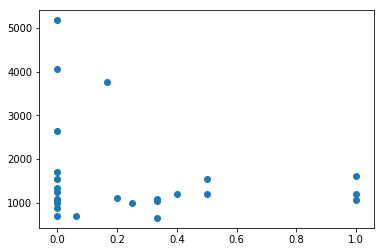

In [303]:
plt.scatter(promise_with_info.ratio, promise_with_info.num_households)

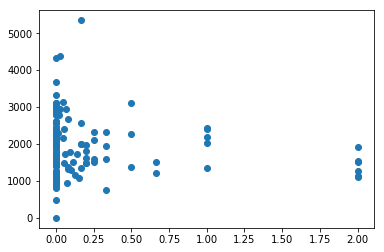

In [304]:
plt.scatter(other_with_info.ratio, other_with_info.num_households)

In [ ]:
# Already we can see that concerns about heteroscedasticity may arise if we wish to use linear regression!

In [229]:
%matplotlib inline

In [174]:
import numpy as np

In [225]:
income_group_to_value = {
    "Less than $15,000": 7500,
    "$15,000 to $29,999": 15000 + 7500,
    "$30,000 to $44,999": 30000 + 7500,
    "$45,000 to $59,999": 45000 + 7500,
    "$60,000 to $74,999": 60000 + 7500,
    "$75,000 to $99,999": 75000 + 12400,
    "$100,000 to $124,999": 100000 + 12400,
    "$125,000 to $149,999": 125000 + 12400,
}

order = [
    "Less than $15,000",
    "$15,000 to $29,999",
    "$30,000 to $44,999",
    "$45,000 to $59,999",
    "$60,000 to $74,999",
    "$75,000 to $99,999",
    "$100,000 to $124,999",
    "$125,000 to $149,999"
]

In [334]:
# Creating a dataframe of ratios, with additional info columns for:
# - Corresponding tract
# - Whether or not in Promise Zone
# - Median income group for that tract
# - Median income as an estimated value for that tract (simply the midpoint of the bin range)
# - Number of households for that tract
all_info = pd.DataFrame(
    pd.concat([
        promise_with_info.assign(promise=1),
        other_with_info.assign(promise=0)
    ], sort=False).drop(["SHAPE_LEN", "geometry", "index_right", "Juris", "Name", "objectid", "code"], axis=1)
)

all_info["median_income"] = all_info.median_group.replace(income_group_to_value)

In [335]:
all_info.groupby("promise").ratio.mean()

promise
0    0.176882
1    0.233814
Name: ratio, dtype: float64

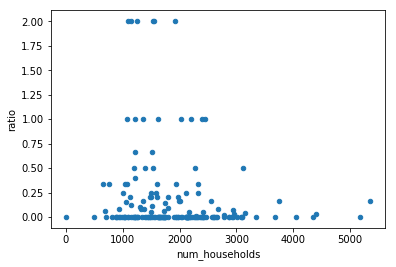

In [336]:
all_info.plot(x="num_households", y="ratio", kind="scatter")

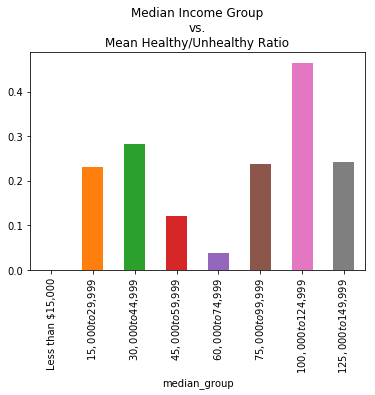

In [677]:
all_info.groupby("median_group").ratio.mean().reindex(order).plot(kind="bar").set_title("Median Income Group\nvs.\nMean Healthy/Unhealthy Ratio");

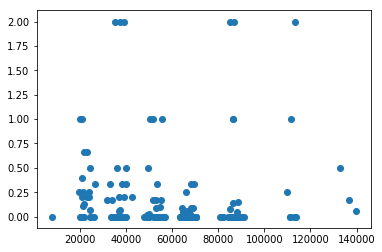

In [324]:
plt.scatter(all_info.median_income + np.random.normal(scale=2000, size=len(all_info)), all_info.ratio)

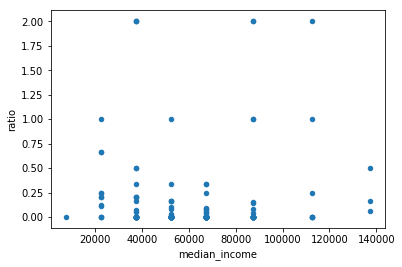

In [325]:
all_info.where(all_info.promise == 0).plot.scatter("median_income", "ratio")

In [493]:
promise_mask = all_info.promise == 1
promise, other = all_info[promise_mask], all_info[~promise_mask]

In [515]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [549]:
possible_groups = socio_geo["INCOME GROUP"].unique()
possible_groups

ordenc = OrdinalEncoder(categories=[possible_groups])
# ordenc.fit(possible_groups.reshape(-1, 1))

# y_train, y_test = ordenc.transform(y_train.to_frame()).ravel(), ordenc.transform(y_test.to_frame()).ravel()

In [672]:
def income_to_ratio_regression(df, reg=LinearRegression()):
    """
    Takes in a dataframe of info, either for all tracts both Promise Zone and Ohter, or just one category.
    
    Uses linear regression to predict the ratio for each tract, and produces a bar plot of the true
    ratios versus the predicted ratios.
    """

    X = df.drop(["healthy_count", "unhealthy_count", "ratio", "TRACT"], axis=1)
    y = df["ratio"]

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    pl = Pipeline([
        ("pre", ColumnTransformer([
            ("groups", ordenc, ["median_group"])
        ], remainder="passthrough")),
        ("reg", reg)
    ])

    pl.fit(X_train, y_train)

    y_test.sort_index().plot(kind="bar", color="blue", width=0.8, alpha=0.8)
    plt.bar(y_test.sort_index().index, pl.predict(X_test), color="orange", width=0.8, alpha=0.7)

    return pl.score(X_test, y_test)

0.042598147746999326

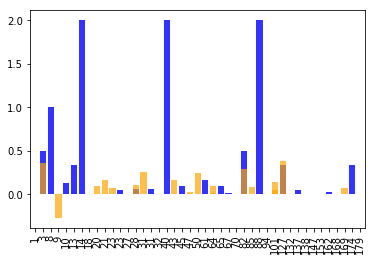

In [673]:
income_to_ratio_regression(all_info)

-0.28328626679846436

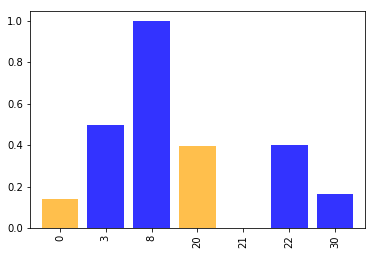

In [674]:
income_to_ratio_regression(promise)

-0.010021574074648099

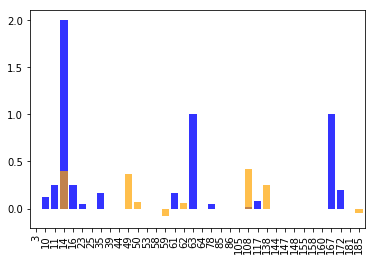

In [675]:
income_to_ratio_regression(other)

0.0009978637781826727

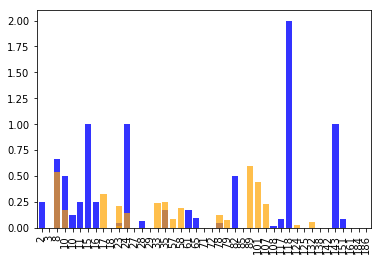

In [676]:
# Let's try it with RandomForestRegressor instead.
income_to_ratio_regression(all_info, RandomForestRegressor(100))

-0.9912226572034679

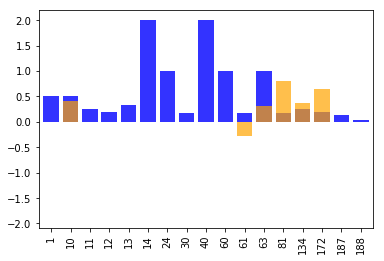

In [682]:
# Maybe the linear regression is getting confused by all of the zeros... what happens if we drop them?
income_to_ratio_regression(all_info[all_info.ratio > 0])

-7.942851494419953

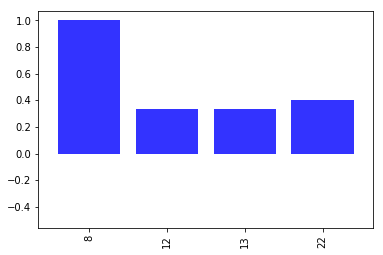

In [687]:
income_to_ratio_regression(promise[promise.ratio > 0])

-14.061215593949678

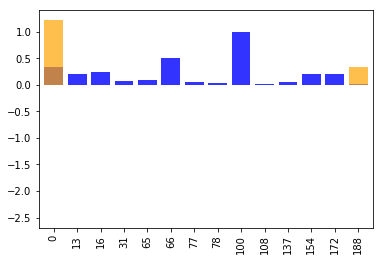

In [688]:
income_to_ratio_regression(other[other.ratio > 0])

In [625]:
# None of these are very good regressors! They are **very** far from being accurate nor precise.

In [626]:
# What if we try predicting median income group using the ratio?

def ratio_to_income_classification(df):
    """
    Takes in a dataframe of info, either for all tracts both Promise Zone and Ohter, or just one category.
    
    Uses random forest classification to predict median income group for each tract, and produces a scatter
    plot of the true group versus the predicted group.
    """
    
    cols_to_delete = df.filter(regex=r"median|\$").columns

    X = df.drop([*cols_to_delete, "TRACT"], axis=1)
    y = ordenc.fit_transform(df.median_group.to_frame()).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf = RandomForestClassifier(100)

    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [627]:
ratio_to_income_classification(all_info)

0.3023255813953488

In [628]:
ratio_to_income_classification(promise)

0.42857142857142855

In [629]:
ratio_to_income_classification(other)

0.3055555555555556

In [633]:
# The classification of median income group based primarily on ratio is *decent* when you
# consider that there are eight categories to choose from...

### Part 2 Discussion of Linear Regression Results

As we expected, it is challenging to create a very useful model from the data we currently have our hands on.  However, there are still trends in our data that are highlighted by the predictive models.

There is indeed some relationship between income level counts in a tract and that tract's corresponding healthy/unhealthy ratio.  This can be seen in the exploratory histogram of "Median Income Group vs Mean Healthy/Unhealthy Ratio"—there is a spike in the ratio at the 100k-125k median income range (which is very high for a median!)

First we tried using linear regression in order to predict the healthy/unhealthy ratio of a tract.  As inputs to this regression model, we fed in: all income group counts, the median income group, the total number of households, and whether or not the tract was in the Promise Zone.  This was very ineffective, and wildly inconsistent—often times predicting negative values or all zeros depending on the training set.  We had a theory that the massive volume of '0' ratios may have been negatively impacting the accuracy of the linear regression, so we tested our regression model with all the zeros removed, but we saw little improvement.

We also tried using random forest regression instead of linear regression and noticed a moderate improvement, but still a huge amount of inconsistency.

Next, we tried using random forest classification in order to predict the median income group of a tract.  This model resulted in an average test accuracy of approximately 33%, which seems bad, but is actually fairly good when you consider that there are eight income groups to choose from, and that we only scored on accuracy (which is a very harsh metric) when instead we should have taken the ordinality of the data into account.  Given more time, we would have liked to have computed a score that would take the distance between the predicted income level and the true income level into account, but we ran into issues while trying to get sklearn to use a different metric on our predictions.  However, this goes to show that there is definitely *some* merit to predicting a median income level for a census tract based on the healthy/unhealthy ratio.

Perhaps one of the biggest issue we discovered while trying to run regression and classification was that the randomly sampled training set had a massive impact on the outcome of the model.  This is largely due to the small size of our dataset compared to the large degree of variation in the data—which was only accentuated when we passed in a partial dataset (e.g. only Promise Zone tracts) to the model.

6. Generate a map showing the ratio of healthy and not healthy food options, and the locations of stores offering healthy food options. 

In [143]:
sdcity = sandiego[sandiego.objectid==40]

sd_healthy_businesses = healthy_businesses_2230.where(
    healthy_businesses_2230.within(sdcity.geometry.item())
)

sd_unhealthy_businesses = unhealthy_businesses_2230.where(
    unhealthy_businesses_2230.within(sdcity.geometry.item())
)

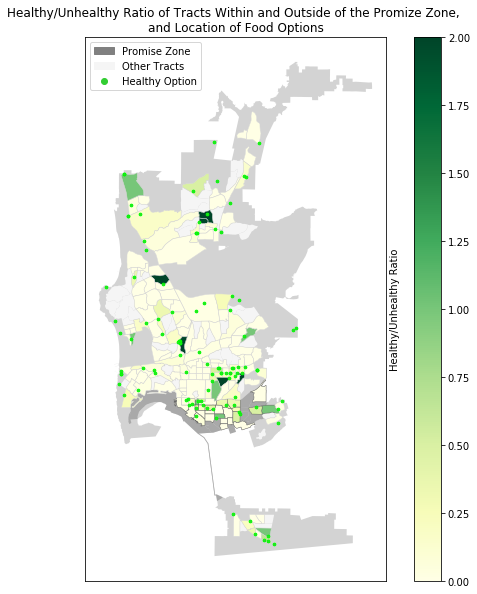

In [664]:
# %matplotlib notebook

ax = sdcity.plot(figsize=(10,10), color="lightgray", label="San Diego City")

promise_tracts.plot(ax=ax, color="darkgray", label="Promise Zone")
sd_city_tracts_not_promise.plot(ax=ax, color="whitesmoke", label="Other Tracts")

# We need to make sure that the promise tracts and other tracts are plotted on the same color range.
#
# We do this by setting vmin and vmax to the same values.  (Also this means we only need to create
# the legend for one of the instances!)
#
# The vmin should be zero (if there are no healthy food options), and the vmax should be the maximum
# ratio found.
max_ratio = max(promise_tracts_health.ratio.max(), other_tracts_health.ratio.max())

cmap = "YlGn"

promise_tracts_health.dropna(subset=["ratio"]).plot(
    ax=ax, column="ratio", cmap=cmap, vmin=0, vmax=max_ratio, edgecolor="dimgray", linewidth=0.5,
    label="Healthy/Unhealthy Ratio", legend=True
)
other_tracts_health.dropna(subset=["ratio"]).plot(
    ax=ax, column="ratio", cmap=cmap, vmin=0, vmax=max_ratio, edgecolor="lightgray", linewidth=0.5
)


# There are a very large number of unhealthy options that are often closely grouped, the alpha is
# set lower than that for healthy options for visual clarity.
#
# NOTE: The prompt asks for just the locations of health food options.
msize=5
sd_healthy_businesses.plot(ax=ax, color="limegreen", alpha=1, markersize=msize+2, edgecolor="lime")
# sd_unhealthy_businesses.plot(ax=ax, color="r", alpha=0.3, markersize=msize)


# Tedious legend work.
promise_patch = mpatches.Patch(color="gray", label="Promise Zone")
other_patch = mpatches.Patch(color="whitesmoke", label="Other Tracts")
healthy_patch = mlines.Line2D([], [], color="limegreen", linestyle='', marker='o', label="Healthy Option")
unhealthy_patch = mlines.Line2D([], [], color='r', linestyle='', marker='o', label="Unhealthy Option")
ax.legend(handles=[promise_patch, other_patch, healthy_patch], bbox_to_anchor=(0, 1), loc=2)
ax.set_ylabel("Healthy/Unhealthy Ratio")
ax.yaxis.set_label_position("right")
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

ax.set_title(
    "Healthy/Unhealthy Ratio of Tracts Within and Outside of the Promize Zone, \nand Location of Food Options"
);

```
# Could you briefly present what you found (up to 5 mins) to start the discussion and get Greg's feedback?  You can demo your notebook, show some resultant graph, and talk through the results.
```